In [1]:
import os
import logging
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import argparse
import time
import mlflow
import json
import pandas as pd
from qiskit import Aer
from qiskit.algorithms.optimizers import ADAM, COBYLA, SLSQP, NELDER_MEAD, SPSA, L_BFGS_B, GradientDescent
from qiskit.algorithms import QAOA, NumPyMinimumEigensolver
from qiskit.utils import QuantumInstance
from qiskit_optimization.applications import Maxcut
from qiskit.circuit import Parameter, ParameterVector
from matplotlib.colors import LinearSegmentedColormap



# Custom imports
from haqc.generators.graph_instance import create_graphs_from_all_sources, GraphInstance
from haqc.exp_utils import (
    str2bool,
    to_snake_case,
    make_temp_directory,
    check_boto3_credentials,
)
from haqc.features.graph_features import get_graph_features
from haqc.generators.parameter import get_optimal_parameters
from haqc.solutions.solutions import compute_max_cut_brute_force, compute_distance
from haqc.parallel.landscape_parallel import parallel_computation, parallel_computation_n_layers_fixed
from haqc.initialisation.initialisation import Initialisation
from haqc.initialisation.initialisation import lookup_optimal_values
from haqc.plot.utils import *
from haqc.initialisation.parameter_fixing import get_optimal_parameters_from_parameter_fixing
from haqc.utils import adjacency_matrix_to_graph


from qiskit.algorithms.optimizers import Optimizer, OptimizerResult
from scipy.optimize import minimize
from haqc.algorithms.custom_optimizers import OptimiseLayerGreaterThanP, OptimizationTracker



# Logger setup
logging.basicConfig(
    level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s'
)
qiskit_logger = logging.getLogger('qiskit')
qiskit_logger.setLevel(logging.ERROR)  # or use logging.CRITICAL
logging.info('Script started')

import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=FutureWarning, module='pandas.core.frame')


2024-04-17 14:47:20,665 - INFO - Script started


In [2]:
json_file_path = "../data/ml-model-landscape.json"

MAX_LAYERS = 15  # Maximum number of layers to optimize for
MESH_SIZE = 100  # Mesh size for the landscape plot
seed = 1024182


with open(json_file_path, "r") as file:
    data = json.load(file)


In [3]:
test_dat = [data[0], data[6]]

In [4]:
for i in test_dat:
    print(i["graph_type"])

Uniform Random
4-Regular Graph


In [5]:
backend = Aer.get_backend('aer_simulator_statevector')
quantum_instance = QuantumInstance(
    backend, 
    seed_simulator=seed, 
    seed_transpiler=seed
)

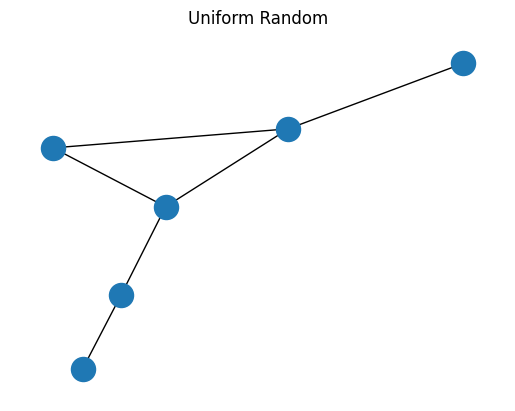

In [18]:
G = adjacency_matrix_to_graph(test_dat[0]["graph"]["adjacency_matrix"])
plt.figure()  
plt.title(test_dat[0]["graph_type"])
nx.draw(G)

In [19]:
# Solving for Exact Ground State using Brute Force for reference
max_cut_partition, max_cut_value = compute_max_cut_brute_force(G)
print(f"MAXCUT Partition: {max_cut_partition}")
print(f"MAXCUT Value: {max_cut_value}")

MAXCUT Partition: (0, 5)
MAXCUT Value: 5


In [20]:
tracker = OptimizationTracker()
optimal_params = []

In [21]:
for N_LAYERS in range(2, MAX_LAYERS + 1):
    print(f"\n {'-'*10} Processing {N_LAYERS} layers {'-'*10}\n\n")

    tracker.set_layer(N_LAYERS)

    if N_LAYERS == 2:
        # For layer 2, fetch initial optimal parameters
        optimal_params_n_layer = lookup_optimal_values(test_dat[0]["graph_type"])
        print(f"Initial optimal parameters for layer {N_LAYERS}: {optimal_params_n_layer}")
        fixed_betas = [optimal_params_n_layer[0]]
        fixed_gammas = [optimal_params_n_layer[1]]
    else:
        # For layers > 2, use the last optimal parameters from the previous layer
        optimal_params_n_layer = optimal_params[-1]  # Last entry from the optimal parameters list
        print(f"Using best optimized parameters from Layer {N_LAYERS - 1}: {optimal_params_n_layer}")
        half_length = len(optimal_params_n_layer) // 2
        fixed_betas = optimal_params_n_layer[:half_length]
        fixed_gammas = optimal_params_n_layer[half_length:]

    ws_init_point = fixed_betas + [np.random.rand()] + fixed_gammas + [np.random.rand()]
    # Define the optimizers for QAOA
    algos_optimizers = [
        ('QAOA', 'Strict-Layer-Fix', OptimiseLayerGreaterThanP(
            fixed_betas=fixed_betas, 
            fixed_gammas=fixed_gammas,
        ), None),
#         ('QAOA', 'Random', NELDER_MEAD(maxfev=1000), 'random'),
#         ('QAOA', 'Layer-WS', NELDER_MEAD(maxfev=1000), ws_init_point)
    ]

    for optimizer in algos_optimizers:
        print(f"Solving with {optimizer[1]} strategy")


        tracker.set_optimizer_name(optimizer[1])

        if optimizer[1] == "Random":
            initial_point = np.concatenate([np.random.uniform(-np.pi/4, np.pi/4, N_LAYERS), np.random.uniform(-np.pi, np.pi, N_LAYERS)]).tolist()
        else:
            initial_point = optimizer[3]


        print(f"Initial Point: {initial_point}")

        qaoa = QAOA(
            optimizer=optimizer[2],
            reps=N_LAYERS,
            initial_point=initial_point,
            callback=tracker.store_intermediate_result,  # Use method from the tracker instance
            quantum_instance=quantum_instance
        )

        adjacency_matrix = nx.adjacency_matrix(G)
        max_cut = Maxcut(adjacency_matrix)
        qubitOp, offset = max_cut.to_quadratic_program().to_ising()
        qaoa.compute_minimum_eigenvalue(qubitOp)

        # Extract the last values (optimal parameters) from the tracker for each optimizer
        last_optimal = tracker.intermediate_values[-1]['parameters']
        min_energy = tracker.intermediate_values[-1]['energy']
        print(f"Minimum energy found {min_energy}")
        print(f"Minimum energy parameters for {optimizer[1]}: {last_optimal}")


        print(f"Optimization Complete for {optimizer[1]} \n \n \n")
        
    print(f"Solved layer {N_LAYERS} using all techniques")
    layer_n_data = [d for d in tracker.intermediate_values if d['layer'] == N_LAYERS]
    best_result = min(layer_n_data, key=lambda x: x['energy'])
    best_result['parameters'] = best_result['parameters'].tolist()
    print(f"Minimum Energy Found: {best_result['energy']} \n")
    print(json.dumps(best_result, indent=4))

    # Update optimal parameters for the current layer with the best results from the last optimizer run
    optimal_params.append(best_result['parameters'])


 ---------- Processing 2 layers ----------


Initial optimal parameters for layer 2: [0.34683182895631315, 2.4350484657974487]
Solving with Strict-Layer-Fix strategy
Initial Point: None
Minimum energy found -1.15447047548354
Minimum energy parameters for Strict-Layer-Fix: [ 0.34683183 -1.99174807  2.43504847 -1.79790519]
Optimization Complete for Strict-Layer-Fix 
 
 

Solved layer 2 using all techniques
Minimum Energy Found: -1.15447047548354 

{
    "iteration": 63,
    "parameters": [
        0.34683182895631315,
        -1.9917480650071462,
        2.4350484657974487,
        -1.7979051880009194
    ],
    "energy": -1.15447047548354,
    "std": 0.0,
    "optimizer": "Strict-Layer-Fix",
    "layer": 2
}

 ---------- Processing 3 layers ----------


Using best optimized parameters from Layer 2: [0.34683182895631315, -1.9917480650071462, 2.4350484657974487, -1.7979051880009194]
Solving with Strict-Layer-Fix strategy
Initial Point: None
Minimum energy found -1.29047359692004
Minimum 

Minimum energy found -1.4377935022232329
Minimum energy parameters for Strict-Layer-Fix: [ 0.34683183 -1.99174807 -4.56219545 -1.57274829  6.15517366 -0.02775767
 -4.76729181 -1.58132757 -6.27296744 -4.72361274  2.43504847 -1.79790519
 -2.14361499 -6.11175676 -3.13097435 -5.46202762 -3.97904809 -3.34855937
  4.82633449 -2.87550006]
Optimization Complete for Strict-Layer-Fix 
 
 

Solved layer 10 using all techniques
Minimum Energy Found: -1.4377935022232329 

{
    "iteration": 70,
    "parameters": [
        0.34683182895631315,
        -1.9917480650071462,
        -4.56219545169973,
        -1.5727482902838958,
        6.155173657355641,
        -0.027757670112540465,
        -4.767291805822353,
        -1.581327570336737,
        -6.272967439828008,
        -4.723612744914653,
        2.4350484657974487,
        -1.7979051880009194,
        -2.1436149858577864,
        -6.111756757676925,
        -3.130974347662417,
        -5.462027622790455,
        -3.9790480890853637,
        -3

Minimum energy found -1.4380134119047394
Minimum energy parameters for Strict-Layer-Fix: [ 0.34683183 -1.99174807 -4.56219545 -1.57274829  6.15517366 -0.02775767
 -4.76729181 -1.58132757 -6.27296744 -4.72361274 -6.2790992   3.14148575
  3.1429712   1.57383919 -3.13990499  2.43504847 -1.79790519 -2.14361499
 -6.11175676 -3.13097435 -5.46202762 -3.97904809 -3.34855937  4.82633449
 -2.87550006  4.34484762  2.63469422 -0.80288132  1.92077742  4.5428752 ]
Optimization Complete for Strict-Layer-Fix 
 
 

Solved layer 15 using all techniques
Minimum Energy Found: -1.4380134119048147 

{
    "iteration": 114,
    "parameters": [
        0.34683182895631315,
        -1.9917480650071462,
        -4.56219545169973,
        -1.5727482902838958,
        6.155173657355641,
        -0.027757670112540465,
        -4.767291805822353,
        -1.581327570336737,
        -6.272967439828008,
        -4.723612744914653,
        -6.279099197881377,
        3.1414857479936904,
        3.142971196279163,
    

In [22]:
# Solve for the minimum energy using the NumPyMinimumEigensolver
exact = NumPyMinimumEigensolver()
adjacency_matrix = nx.adjacency_matrix(G)
max_cut = Maxcut(adjacency_matrix)
qubitOp, offset = max_cut.to_quadratic_program().to_ising()
result = exact.compute_minimum_eigenvalue(qubitOp)
print(f"Exact Ground State Energy: {result.eigenvalue.real}")
print(f"Exact Ground State Eigenstate: {result.eigenstate}")

Exact Ground State Energy: -2.0
Exact Ground State Eigenstate: VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j],
            dims=(2, 2, 2, 2, 2, 2)))


   iteration                                         parameters    energy  \
0          1  [0.34683182895631315, -1.5273702772188447, 2.4...  0.528244   
1          2  [0.34683182895631315, -1.603738791079787, 2.43...  0.134818   
2          3  [0.34683182895631315, -1.5273702772188447, 2.4...  0.529696   
3          4  [0.34683182895631315, -1.603738791079787, 2.43...  0.139880   
4          5  [0.34683182895631315, -1.6801073049407291, 2.4... -0.239745   

   std         optimizer  layer  
0  0.0  Strict-Layer-Fix      2  
1  0.0  Strict-Layer-Fix      2  
2  0.0  Strict-Layer-Fix      2  
3  0.0  Strict-Layer-Fix      2  
4  0.0  Strict-Layer-Fix      2  
Strict-Layer-Fix    1136
Name: optimizer, dtype: int64


<Figure size 640x480 with 0 Axes>

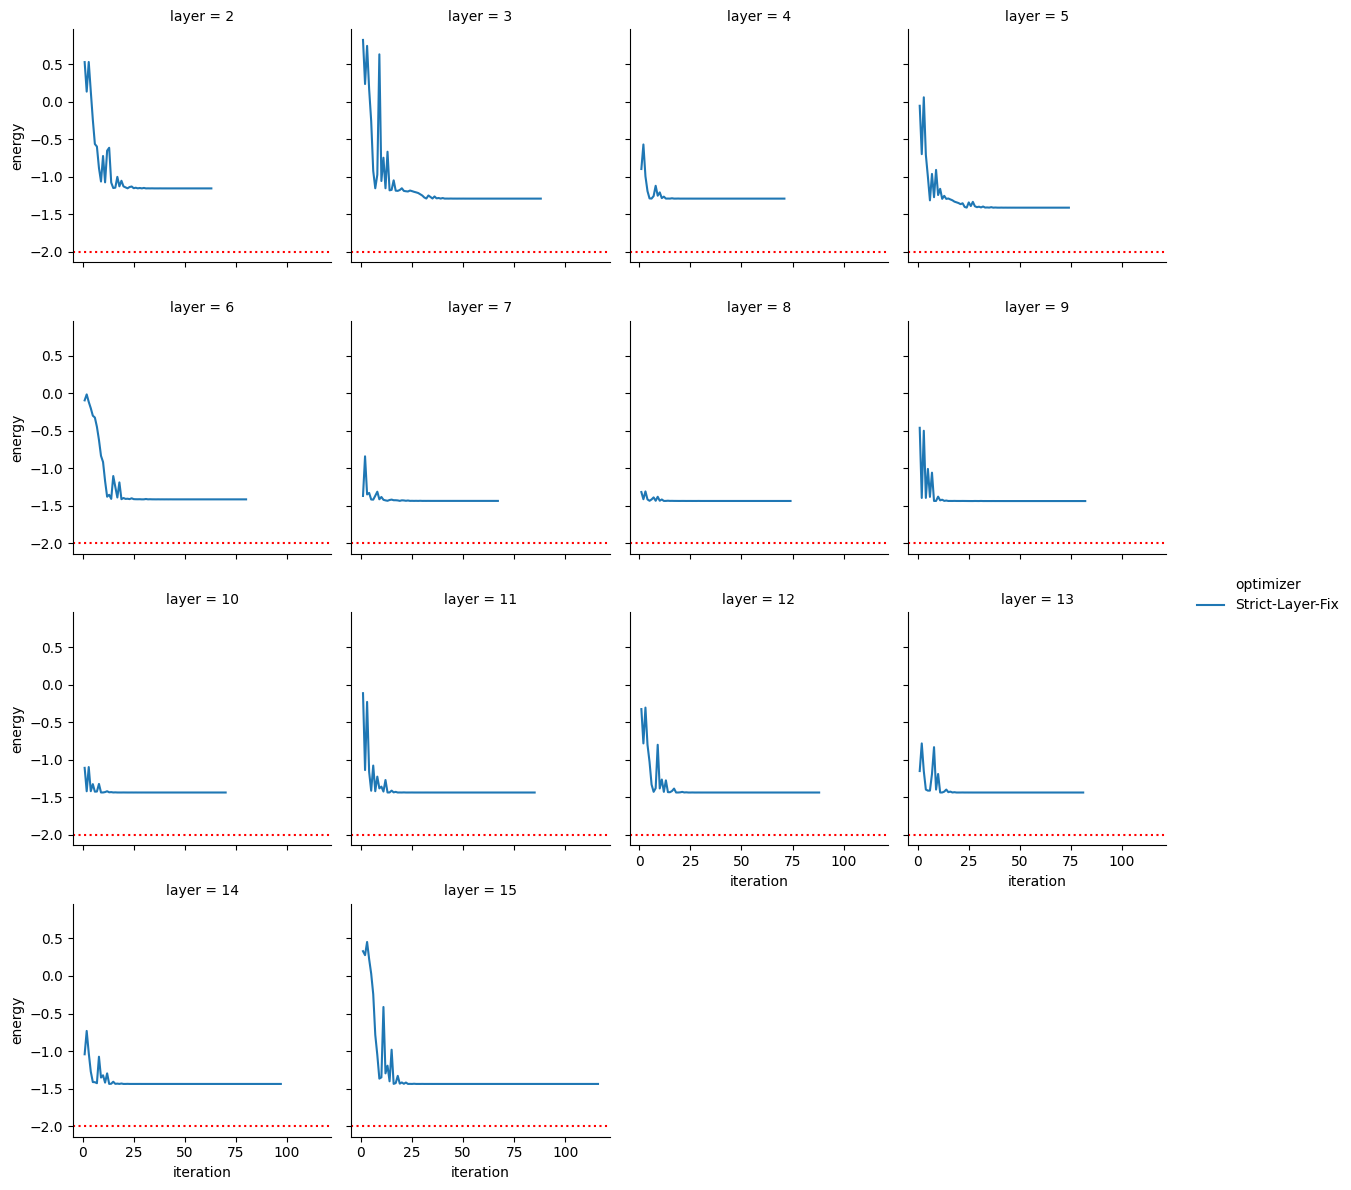

In [23]:
results_df = pd.DataFrame(tracker.intermediate_values)
print(results_df.head())
print(results_df.optimizer.value_counts())

results_df['parameters_str'] = results_df['parameters'].apply(lambda x: ', '.join(map(str, x)))

# Clear existing plots
plt.clf()
# Create the FacetGrid
g = sns.FacetGrid(results_df, col='layer', hue='optimizer', col_wrap=4, sharey=True, legend_out=True)
g = g.map(plt.plot, 'iteration', 'energy').add_legend()

# Add a horizontal line at y = -3, dotted
g.map(plt.axhline, y=result.eigenvalue.real, linestyle=':', color='red')

plt.show()

In [24]:
results_df['parameters'] = results_df['parameters'].apply(lambda x: ', '.join(map(str, x)))

In [25]:
results_df

,iteration,parameters,energy,std,optimizer,layer,parameters_str
0,1,"0.34683182895631315, -1.5273702772188447, 2.43...",0.528244,0.0,Strict-Layer-Fix,2,"0.34683182895631315, -1.5273702772188447, 2.43..."
1,2,"0.34683182895631315, -1.603738791079787, 2.435...",0.134818,0.0,Strict-Layer-Fix,2,"0.34683182895631315, -1.603738791079787, 2.435..."
2,3,"0.34683182895631315, -1.5273702772188447, 2.43...",0.529696,0.0,Strict-Layer-Fix,2,"0.34683182895631315, -1.5273702772188447, 2.43..."
3,4,"0.34683182895631315, -1.603738791079787, 2.435...",0.139880,0.0,Strict-Layer-Fix,2,"0.34683182895631315, -1.603738791079787, 2.435..."
4,5,"0.34683182895631315, -1.6801073049407291, 2.43...",-0.239745,0.0,Strict-Layer-Fix,2,"0.34683182895631315, -1.6801073049407291, 2.43..."
...,...,...,...,...,...,...,...
1131,112,"0.34683182895631315, -1.9917480650071462, -4.5...",-1.438013,0.0,Strict-Layer-Fix,15,"0.34683182895631315, -1.9917480650071462, -4.5..."
1132,113,"0.34683182895631315, -1.9917480650071462, -4.5...",-1.438013,0.0,Strict-Layer-Fix,15,"0.34683182895631315, -1.9917480650071462, -4.5..."
1133,114,"0.34683182895631315, -1.9917480650071462, -4.5...",-1.438013,0.0,Strict-Layer-Fix,15,"0.34683182895631315, -1.9917480650071462, -4.5..."
1134,115,"0.34683182895631315, -1.9917480650071462, -4.5...",-1.438013,0.0,Strict-Layer-Fix,15,"0.34683182895631315, -1.9917480650071462, -4.5..."


In [26]:
data_dict = results_df.to_dict(orient="records")

In [27]:
with open('output-unif-random-test.json', 'w') as file:
    json.dump(data_dict, file)